In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# List of Imports
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

import sympy as sp

Using TensorFlow backend.


# Parameters (Sliding Window)

In [4]:
LABELS = ['Fall','Non Fall']
le = preprocessing.LabelEncoder()
LABEL = 'ActivityEncoded'
TIME_PERIODS = 80
STEP_DISTANCE = 40

# Importing Data

In [16]:
def df(value):
    
    if value == 0:
        df_stats_A = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\Stats\df with stats A.csv')
        df_test_A  = df_stats_A[df_stats_A['User'] > 38]
        df_train_A = df_stats_A[df_stats_A['User'] <= 38]
    if value == 1:
        df_test_A = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df test SMOTE A with stats.csv')
        df_train_A = pd.read_csv(r'C:\Users\Ash\Desktop\MobiFall Datasets cleaned\SMOTE\df train SMOTE A with stats.csv')

    return df_test_A,df_train_A

STATS = 0
SMOTE_STATS = 1

df_test,df_train = df(STATS)
df_test.head()

,Unnamed: 0,User,Activity,Ax,Ay,Az,ActivityEncoded,Max,Min,Mean,Median,Std,Mad,SMV
30152,0,39,Fall,1.072602,9.691729,0.497994,0,9.691729,0.497994,3.754108,1.072602,5.150150,3.958414,9.763610
30153,1,39,Fall,1.110910,9.624691,0.296881,0,9.624691,0.296881,3.677494,1.110910,5.166481,3.964798,9.693139
30154,2,39,Fall,1.043872,9.662998,0.392649,0,9.662998,0.392649,3.699840,1.043872,5.174501,3.975439,9.727146
30155,3,39,Fall,1.034295,9.682152,0.507571,0,9.682152,0.507571,3.741339,1.034295,5.151631,3.960542,9.750460
30156,4,39,Fall,1.053449,9.730036,0.957681,0,9.730036,0.957681,3.913722,1.053449,5.037303,3.877543,9.833642


# Creating Sliding Window

In [19]:
#This functions creates segments of the training set, essentially creating a better form that will be accepted by KERAS but can also be used by supervised learning 



def create_segments_and_labels(df, time_steps, step, label_name):

    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['Ax'].values[i: i + time_steps]
        ys = df['Ay'].values[i: i + time_steps]
        zs = df['Az'].values[i: i + time_steps]
     
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)


    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

def create_segments_and_labels_stats(df, time_steps, step, label_name):

    N_FEATURES = 4
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        Max = df['Max'].values[i: i + time_steps]
        Min = df['Min'].values[i: i + time_steps]
#         Mean = df['Mean'].values[i: i + time_steps]
#         Median = df['Median'].values[i: i + time_steps]
        Std = df['Std'].values[i: i + time_steps]
#         Mad = df['Mad'].values[i: i + time_steps]
        SMV = df['SMV'].values[i: i + time_steps]
        
        labs = [Max,Min,Std,SMV]
    
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append(labs)
        labels.append(label)
        


    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels




In [20]:
##### TRY STANDARIZATION
df_train.head()

,Unnamed: 0,User,Activity,Ax,Ay,Az,ActivityEncoded,Max,Min,Mean,Median,Std,Mad,SMV
0,0,1,Fall,0.890643,-9.576807,-0.019154,0,0.890643,-9.576807,-2.901773,-0.019154,5.798620,4.450023,9.618152
1,1,1,Fall,0.919373,-9.595961,-0.057461,0,0.919373,-9.595961,-2.911349,-0.057461,5.809611,4.456408,9.640073
2,2,1,Fall,0.871489,-9.595961,-0.057461,0,0.871489,-9.595961,-2.927311,-0.057461,5.793868,4.445767,9.635625
3,3,1,Fall,0.852336,-9.643845,-0.038307,0,0.852336,-9.643845,-2.943272,-0.038307,5.819929,4.467049,9.681513
4,4,1,Fall,0.871489,-9.634268,-0.057461,0,0.871489,-9.634268,-2.940080,-0.057461,5.815914,4.462792,9.673775


# Setting up Training Data

In [21]:
# #Raw Signal Data Transform
# x_train, y_train = create_segments_and_labels(df_train,
#                                               TIME_PERIODS,
#                                               STEP_DISTANCE,
#                                               LABEL)
# num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]

# input_shape = (num_time_periods*num_sensors)
# x_train = x_train.reshape(x_train.shape[0], input_shape)

# x_train = x_train.astype('float32')
# y_train = y_train.astype('float32')

# y_train_hot = np_utils.to_categorical(y_train, 2)

#Stat Signal Data Transform
x_train, y_train = create_segments_and_labels_stats(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]

input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

y_train_hot = np_utils.to_categorical(y_train, 2)

# Setting up Testing Data

In [22]:
# # #Raw Signal Data Transform
# x_test, y_test = create_segments_and_labels(df_test,
#                                               TIME_PERIODS,
#                                               STEP_DISTANCE,
#                                               LABEL)
# num_time_periods1, num_sensors1 = x_test.shape[1], x_test.shape[2]
# input_shape1 = (num_time_periods1*num_sensors1)
# x_test = x_test.reshape(x_test.shape[0], input_shape1)
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test_hot = np_utils.to_categorical(y_test, 2)

#Stat Signal Data Transform
x_test, y_test = create_segments_and_labels_stats(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
num_time_periods1, num_sensors1 = x_test.shape[1], x_test.shape[2]
input_shape1 = (num_time_periods1*num_sensors1)
x_test = x_test.reshape(x_test.shape[0], input_shape1)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test_hot = np_utils.to_categorical(y_test, 2)

# Keras Model Architecture

In [23]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, 4), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(2, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 80, 4)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 80, 100)           500       
_________________________________________________________________
dense_6 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_7 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_2 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 16002     
Total params: 36,702
Trainable params: 36,702
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 22939 samples, validate on 5735 samples
Epoch 1/50
22939/22939 [==============================] - 21s 925us/step - loss: 0.2591 - acc: 0.9188 - val_loss: 0.3899 - val_acc: 0.9092
Epoch 2/50
22939/22939 [==============================] - 20s 856us/step - loss: 0.1655 - acc: 0.9434 - val_loss: 0.4277 - val_acc: 0.9092
Epoch 3/50
22939/22939 [==============================] - 21s 901us/step - loss: 0.1429 - acc: 0.9506 - val_loss: 0.8806 - val_acc: 0.8476
Epoch 4/50
22939/22939 [==============================] - 20s 874us/step - loss: 0.1255 - acc: 0.9575 - val_loss: 0.9311 - val_acc: 0.8124
Epoch 5/50
22939/22939 [==============================] - 19s 822us/step - loss: 0.1134 - acc: 0.9632 - val_loss: 0.9865 - val_acc: 0.8119
Epoch 6/50
22939/22939 [==============================] - 19s 813us/step - loss: 0.0971 - acc: 0.9704 - val_loss: 1.0209 - val_acc: 0.8120
Epoch 7/50
22939/22939 [==============================] - 19s 822us/step - loss: 0.0917 - acc: 0.9713 - val_loss: 1.4

# Visualising Results

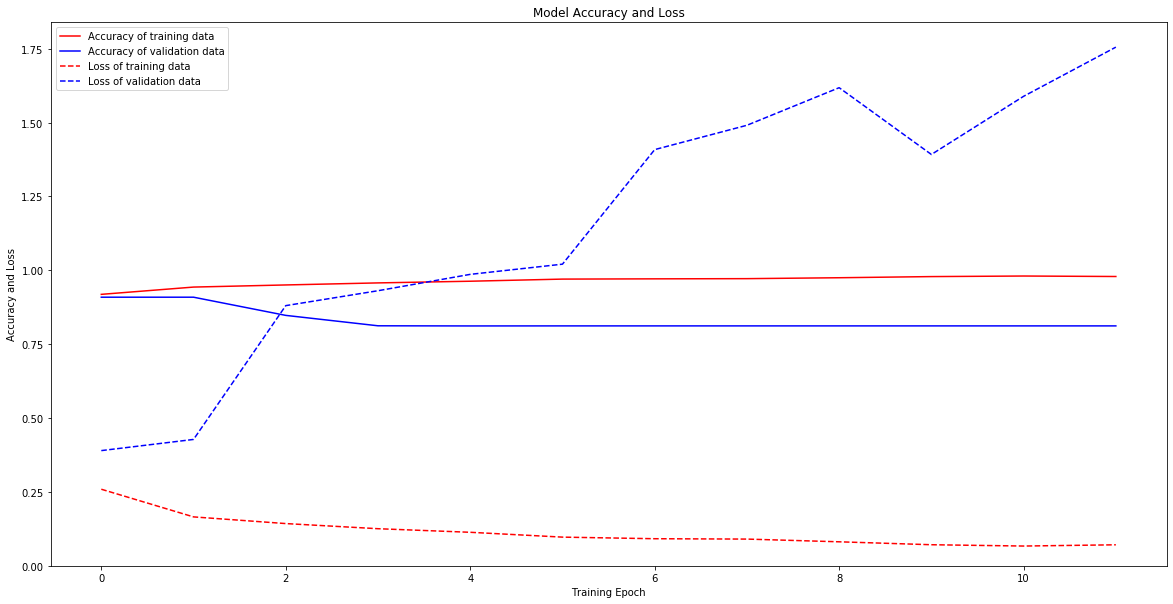

              precision    recall  f1-score   support

         0.0       0.61      0.77      0.68      2262
         1.0       0.98      0.96      0.97     26412

    accuracy                           0.94     28674
   macro avg       0.79      0.86      0.82     28674
weighted avg       0.95      0.94      0.95     28674



In [25]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

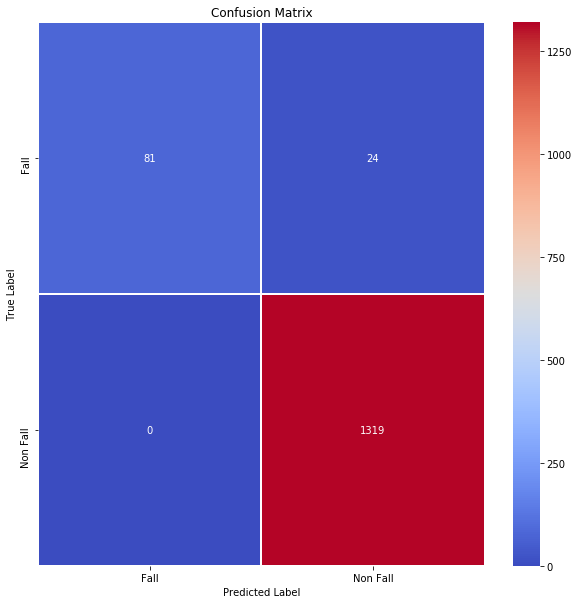

              precision    recall  f1-score   support

           0       1.00      0.77      0.87       105
           1       0.98      1.00      0.99      1319

    accuracy                           0.98      1424
   macro avg       0.99      0.89      0.93      1424
weighted avg       0.98      0.98      0.98      1424



In [26]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(10,10 ))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)

max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

# Plotting ROC Curve

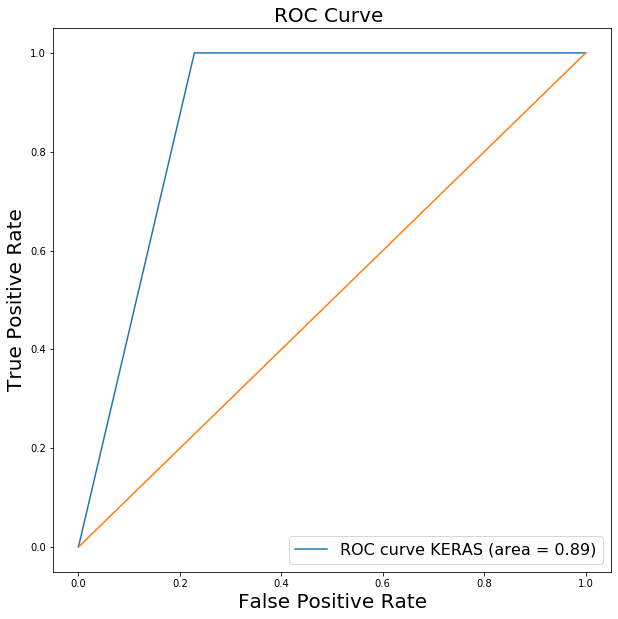

In [27]:
y_pred_ROC = model_m.predict_proba(x_test)
y_pred_ROC_test = np.argmax(y_pred_ROC, axis=1)
fpr , tpr , thresholds = roc_curve( max_y_test , y_pred_ROC_test)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='ROC curve KERAS (area = %0.2f)' % float(roc_auc))
plt.plot([0, 1], [0, 1], '-')
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize = 20)
plt.title('ROC Curve ',fontsize=20)
plt.legend(loc="lower right",fontsize=16)
plt.show()